In [80]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [81]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([np.nan])
          ivddio = np.array([np.nan])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                bad = []
                for i in range(len(postread)-1):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                          if (i + j) % (2**bpc) != postread[i][j]:
                             bad.append([i,j,(i + j) % (2**bpc),postread[i][j]])
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                          if refvec[i][j] != postread[i][j]:
                             bad.append([i,j,refvec[i][j],postread[i][j]])
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                np.savetxt(f"data/confmat/bad_{mode}_{alias}_{att}.csv", bad, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse, "cells": confmat.sum()}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data = data[data["att"] != 3968]
data

1bpc_bwa_0
1bpc_pba_1291
1bpc_bwa_1713
2bpc_bwa_1707
2bpc_pba_1709
[[109281    591     22     11]
 [ 27341  27745  27472  27666]
 [ 27589  27470  27310  27328]
 [ 27561  27403  27529  27637]]
[[109741    157      1      6]
 [ 27322  27755  27477  27670]
 [ 27549  27509  27307  27332]
 [ 27395  27535  27556  27644]]
[[109841     62      0      2]
 [ 27302  27789  27455  27678]
 [ 26999  27976  27391  27331]
 [ 18565  35048  28820  27697]]
[[109876     25      1      3]
 [ 27434  31794  23775  27221]
 [ 26007  26720  30352  26618]
 [   550  13575  63364  32641]]
[[109886     17      0      2]
 [ 34630  73046   2110    438]
 [ 21890  37706  49429    672]
 [     1     44    456 109629]]
[[109891     14      0      0]
 [  2964 106069   1190      1]
 [    43   1390 105258   3006]
 [     4    131    929 109066]]
[[109893     11      0      1]
 [   833 108740    650      1]
 [     2     65 109514    116]
 [     0      1     48 110081]]
[[109893     12      0      0]
 [   430 109462    330     

,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,cells,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_0_cb,1,1,0.017210006713867188,0.016600,NaN,NaN,NaN,5.300956e+07,0.499993,...,879956.0,20000,879958,100000,20000,19999,1659995,1320023,439983,439975
1,1bpc_bwa_0_cb,2,1,0.025251388549804688,0.025006,NaN,NaN,NaN,3.519008e+07,0.499977,...,879956.0,20000,440137,139999,40000,20150,2500580,2636592,879966,440128
2,1bpc_bwa_0_cb,4,1,0.03464674949645996,0.034231,NaN,NaN,NaN,2.570659e+07,0.498234,...,879956.0,20000,439991,180132,80000,20142,3423075,3519833,1759930,440118
3,1bpc_bwa_0_cb,8,1,0.052761077880859375,0.052638,NaN,NaN,NaN,1.671716e+07,0.341109,...,879956.0,20000,437750,260163,159999,20174,5263788,5279298,3517122,440150
4,1bpc_bwa_0_cb,16,1,0.07978272438049316,0.079742,0.005358,4.855854e-10,4.400423e-17,1.103497e+07,0.000114,...,879956.0,20000,59,381482,261246,20277,7974249,7794275,5155005,440254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2bpc_bwa_2011_lfsr,128,2,0.3992753028869629,0.398926,0.004581,2.076947e-09,9.416251e-16,2.205705e+06,0.002746,...,439956.0,10000,753,1842365,642490,889862,39892554,8851893,2752681,2528473
177,2bpc_bwa_2011_lfsr,256,2,0.40247607231140137,0.402599,0.004584,2.097183e-09,9.595551e-16,2.185578e+06,0.002748,...,439956.0,10000,13,1859104,645574,901101,40259923,8908702,2750273,2545331
178,2bpc_bwa_2011_lfsr,512,2,0.4035341739654541,0.403499,0.004610,2.114180e-09,9.694942e-16,2.180705e+06,0.002643,...,439956.0,10000,4,1863065,648303,902189,40349894,8920294,2755653,2552709
179,2bpc_bwa_2011_lfsr,1024,2,0.40529370307922363,0.405121,0.004608,2.121667e-09,9.768374e-16,2.171975e+06,0.002564,...,439956.0,10000,4,1870293,650738,906473,40512066,8935107,2759838,2554760


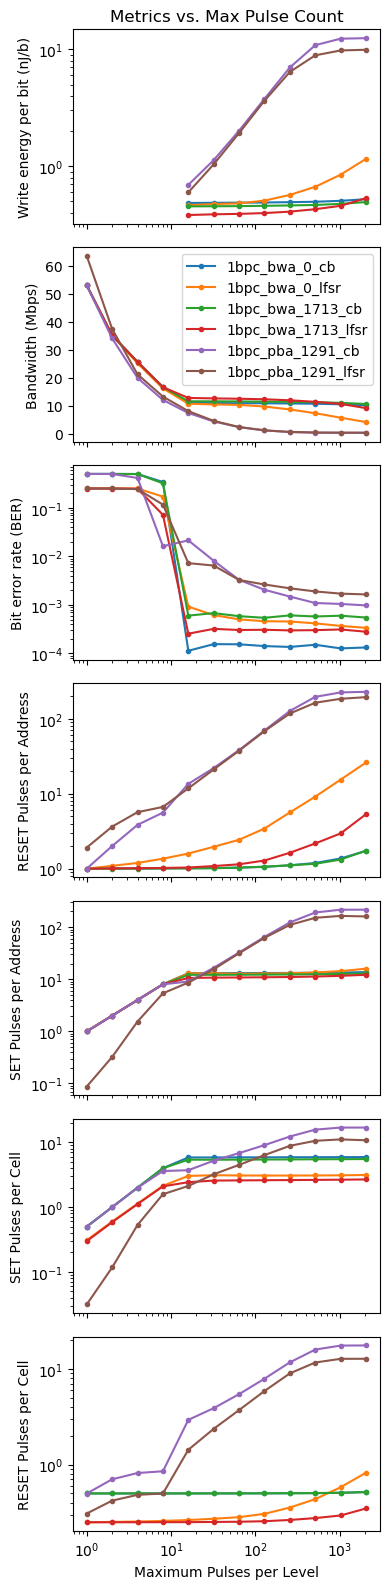

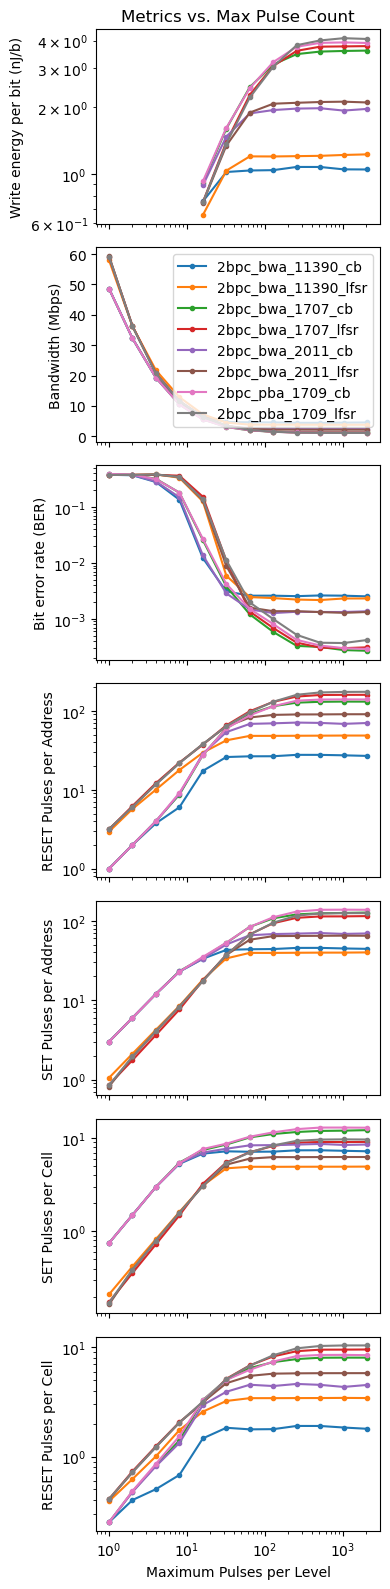

In [82]:
# Plot write BER tradeoff vs. attempts
for bpc in range(1,3):
  fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
  for (bpc, alias), d in data[data["bpc"] == bpc].groupby(["bpc", "alias"]):
    plt.xlabel("Maximum Pulses per Level")
    plt.xscale("log")
    axs[0].set_title(f"Metrics vs. Max Pulse Count")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
    axs[0].set_yscale("log")
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["ber"], ".-", label=alias)
    axs[2].set_yscale("log")
    axs[2].set_ylabel("Bit error rate (BER)")
    axs[3].plot(d["att"], d["resets"]/d["successes"], ".-", label=alias)
    axs[3].set_yscale("log")
    axs[3].set_ylabel("RESET Pulses per Address")
    axs[4].plot(d["att"], d["sets"]/d["successes"], ".-", label=alias)
    axs[4].set_yscale("log")
    axs[4].set_ylabel("SET Pulses per Address")
    axs[5].plot(d["att"], d["set_bits"]/d["cells"], ".-", label=alias)
    axs[5].set_yscale("log")
    axs[5].set_ylabel("SET Pulses per Cell")
    axs[6].plot(d["att"], d["reset_bits"]/d["cells"], ".-", label=alias)
    axs[6].set_yscale("log")
    axs[6].set_ylabel("RESET Pulses per Cell")
  axs[1].legend()
  plt.tight_layout()
  plt.subplots_adjust(hspace=0.12)
  plt.savefig(f"../analysis/figs/{bpc}bpc_metrics.pdf")
  plt.show()